In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [2]:
x_train = pd.read_csv("../data/processed/x_train-prelim.csv", index_col=0, dtype=str)
x_test = pd.read_csv("../data/processed/x_test-prelim.csv", index_col=0, dtype=str)
# Convert y_train, y_test to arrays rather than data frames
y_train = pd.read_csv(
  "../data/processed/y_train.csv", index_col=0, dtype=float
).squeeze("columns")
y_test = pd.read_csv(
  "../data/processed/y_test.csv", index_col=0, dtype=float
).squeeze("columns")

In [3]:
# Apply correct conversion to input features
def get_correct_types_x(df, numeric_cols):
    for col in ['deenergize_time', 'restoration_time']:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
    return df
numeric_cols = [
    'hftd_tier', 'total_affected', 'residential_affected',
    'longitude', 'latitude', 'total_pop', 'tmin_d-4', 'tmax_d-4',
    'wspd_d-4', 'tmin_d-3', 'tmax_d-3', 'wspd_d-3', 'tmin_d-2', 'tmax_d-2',
    'wspd_d-2', 'tmin_d-1', 'tmax_d-1', 'wspd_d-1'
]
x_train = get_correct_types_x(x_train, numeric_cols)
x_test = get_correct_types_x(x_test, numeric_cols)

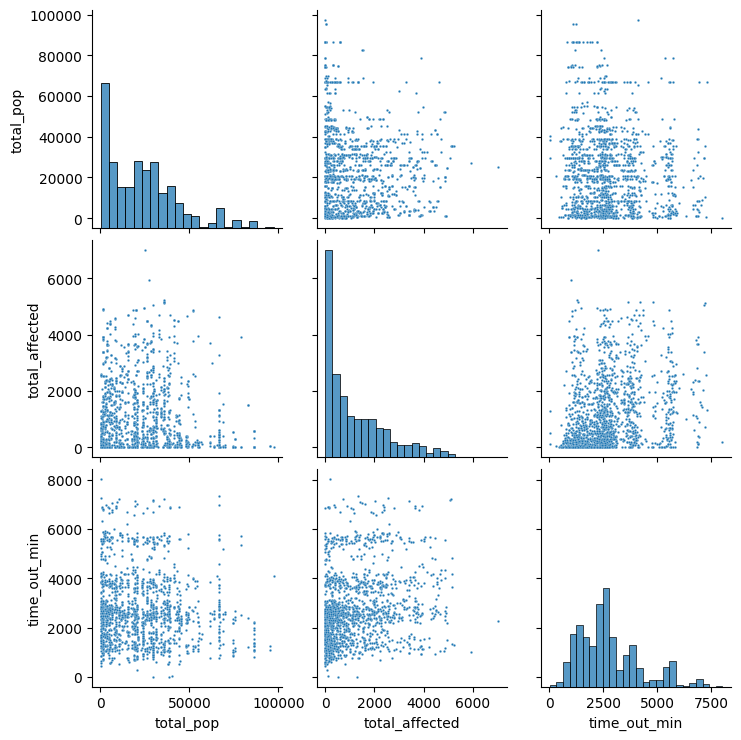

In [4]:
# Plot population vs. total affected vs. outage time
sns.pairplot(
    pd.concat(
        [x_train[['total_pop', 'total_affected']], y_train], axis=1
    ),
    plot_kws={'s': 3}
)
plt.show()

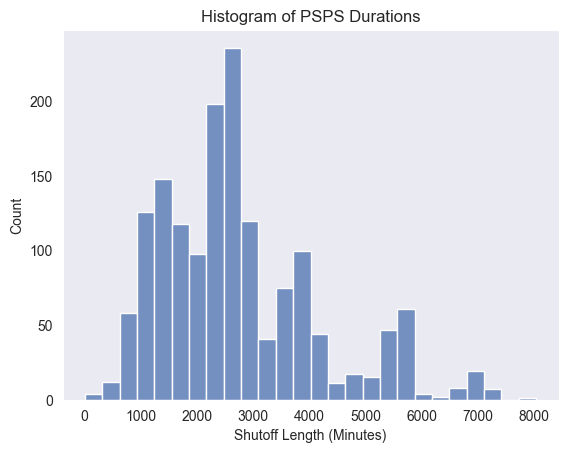

In [5]:
sns.set_style('dark')
sns.set_palette('deep')
sns.histplot(y_train)
plt.xlabel('Shutoff Length (Minutes)')
plt.title('Histogram of PSPS Durations')
plt.savefig('../visuals/psps-shutoff-lengths-hist.jpeg', dpi=300)
plt.show()

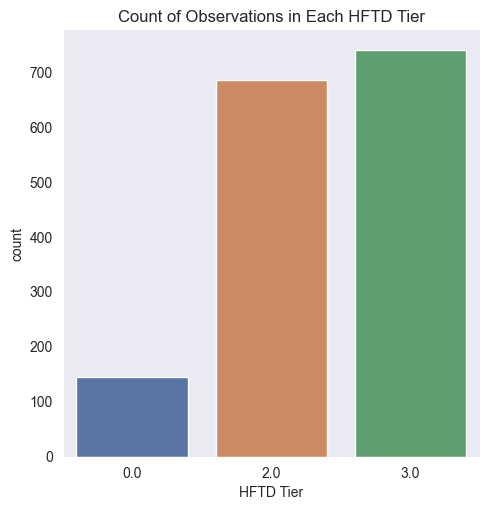

In [6]:
sns.catplot(x_train, x='hftd_tier', kind='count')
plt.xlabel('HFTD Tier')
plt.title('Count of Observations in Each HFTD Tier')
plt.show()

In [7]:
# Univariate Linear Model (ULM)
ulm_x_train = np.array(x_train.total_affected).reshape(-1, 1)
ulm_x_test = np.array(x_test.total_affected).reshape(-1, 1)
ulm = LinearRegression()
ulm.fit(ulm_x_train, y_train)
ulm_preds = ulm.predict(ulm_x_test)
train_devs = ((y_train - y_train.mean()) ** 2).sum()
print("Train RMSE: ", np.sqrt(mean_squared_error(y_train, ulm.predict(ulm_x_train))))
print("Train R-Squared:", 1 - (mean_squared_error(y_train, ulm.predict(ulm_x_train)) * len(y_train)) / train_devs)
print("RMSE of Univariate Linear Regression = ", np.sqrt(mean_squared_error(ulm_preds, y_test)))
# ulm.coef_

Train RMSE:  1376.6823309940219
Train R-Squared: 0.05861724387614797
RMSE of Univariate Linear Regression =  1578.099447125169


In [8]:
# Preliminary linear model based on all data (multiple regression)
cols_for_baseline = [col for col in numeric_cols if col != 'time_out_min']

mlm_x_train = x_train[cols_for_baseline]
mlm_x_test = x_test[cols_for_baseline]
mlm = LinearRegression()
mlm.fit(mlm_x_train, y_train)
mlm_preds = mlm.predict(mlm_x_test)
train_devs = ((y_train - y_train.mean()) ** 2).sum()
print("Train RMSE: ", np.sqrt(mean_squared_error(y_train, mlm.predict(mlm_x_train))))
print("Train R-Squared:", 1 - (mean_squared_error(y_train, mlm.predict(mlm_x_train)) * len(y_train)) / train_devs)
print("RMSE of Multiple Linear Regression = ", np.sqrt(mean_squared_error(mlm_preds, y_test)))

Train RMSE:  1105.6925931150324
Train R-Squared: 0.3927499455145994
RMSE of Multiple Linear Regression =  1155.053925332519


In [9]:
# Preliminary XGBoost model based on all data ("default" hyperparameters)
xgb_params = {'max_depth':6, 'eta':.3, 'objective':'reg:squarederror'}
num_round = 5
d_train = xgb.DMatrix(mlm_x_train, label = y_train)
xgb_model = xgb.train(xgb_params, d_train, num_round)
d_test = xgb.DMatrix(mlm_x_test, label = y_test)
xgb_preds = xgb_model.predict(d_test)
print("RMSE of XGBoost = ", np.sqrt(mean_squared_error(xgb_preds, y_test)))

RMSE of XGBoost =  1027.8605370614034


$$
R^2 = SSR / SST = 1 - SSE / SST
$$

In [10]:
# Calculate RMSE, test R^2 as performance metrics (along with MAE, if necessary)
def calc_test_r2(pred_vals, true_vals, baseline_rmse):
    sse = mean_squared_error(pred_vals, true_vals) * len(true_vals)
    sst = (baseline_rmse ** 2) * len(true_vals)
    return (
        1 - sse / sst, np.sqrt(sse / len(true_vals)),
        mean_absolute_error(pred_vals, true_vals)
    )

In [11]:
baseline_rmse = np.sqrt(((y_test - y_test.mean()) ** 2).mean())
# Concatenate all three preliminary models into single dataframe
prelim_model_results = pd.DataFrame({
    'Model': [
        'Simple Linear Regression', 'Multiple Linear Regression', 'XGBoost'
    ],
    'stats': [
        calc_test_r2(preds, y_test, baseline_rmse)
        for preds in [ulm_preds, mlm_preds, xgb_preds]
    ]
})
prelim_model_results['test_r_sq'] = [
    model[0] for model in prelim_model_results['stats']
]
prelim_model_results['rmse'] = [
    model[1] for model in prelim_model_results['stats']
]
prelim_model_results['mae'] = [
    model[2] for model in prelim_model_results['stats']
]
prelim_model_results.drop(columns='stats', inplace=True)
print(prelim_model_results)

                        Model  test_r_sq         rmse          mae
0    Simple Linear Regression   0.002391  1578.099447  1157.988578
1  Multiple Linear Regression   0.465563  1155.053925   882.595626
2                     XGBoost   0.576786  1027.860537   750.430526
